In [111]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import concurrent.futures
import torch
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# %% Check GPU Availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device (PyTorch):", device)

physical_devices = tf.config.list_physical_devices('GPU')
print("GPU is available (TensorFlow)" if physical_devices else "GPU is not available (TensorFlow)")

Using device (PyTorch): cuda
GPU is not available (TensorFlow)


In [112]:
DATASET_PATHS = {
    "Crema": "../datasets/CREMA_D",
    "Ravdess": "../datasets/RAVDESS",
    "Savee": "../datasets/SAVEE",
    "Tess": "../datasets/TESS",
}

EMOTION_MAPPINGS = {
    "Ravdess": {1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad',
                5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'},
    "Crema": {'SAD': 'sad', 'ANG': 'angry', 'DIS': 'disgust',
              'FEA': 'fear', 'HAP': 'happy', 'NEU': 'neutral'},
    "Tess": {'neutral': 'neutral', 'happy': 'happy', 
             'sad': 'sad', 'angry': 'angry', 
             'fear': 'fear', 'disgust': 'disgust', 'ps': 'surprise'},
    "Savee": {'a': 'angry', 'd': 'disgust', 'f': 'fear',
              'h': 'happy', 'n': 'neutral', 'sa': 'sad'}
}

In [113]:
def load_dataset(dataset_name):
    path = DATASET_PATHS[dataset_name]
    emotion_map = EMOTION_MAPPINGS[dataset_name]
    
    file_emotion, file_path = [], []
    
    for file in os.listdir(path):
        if file.endswith('.wav'):
            if dataset_name == "Ravdess":
                emotion_code = int(file.split('-')[2])
            elif dataset_name == "Crema":
                emotion_code = file.split('_')[2]
            elif dataset_name == "Tess":
                emotion_code = file.split('_')[-1].split('.')[0]
            elif dataset_name == "Savee":
                emotion_code = file.split('_')[1][0]
            else:
                continue

            file_emotion.append(emotion_map.get(emotion_code, 'unknown'))
            file_path.append(os.path.join(path, file))

    return pd.DataFrame({'Emotions': file_emotion, 'Path': file_path})

In [114]:
def combine_datasets():
    dfs = [load_dataset(dataset) for dataset in DATASET_PATHS]
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df[combined_df['Emotions'].isin(['sad', 'angry', 'happy', 'fear', 'neutral'])]


In [115]:
def visualize_emotion_distribution(df):
    emotion_counts = df.groupby(['Emotions']).size()
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')
    plt.title('Emotion Distribution', fontsize=16)
    plt.xlabel('Emotion', fontsize=14)
    plt.ylabel('Number of Samples', fontsize=14)
    plt.tight_layout()
    plt.show()


In [116]:
def extract_features(data, sr):
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data))
    rms = np.mean(librosa.feature.rms(y=data))
    chroma = np.mean(librosa.feature.chroma_stft(y=data, sr=sr))
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sr))
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sr), axis=1)
    
    return np.hstack([zcr, chroma, mfcc, rms, mel])

In [117]:
def augment_data(data, sr):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    noisy = data + noise_amp * np.random.normal(size=data.shape[0])
    stretched = librosa.effects.time_stretch(data, rate=0.8)
    pitched = librosa.effects.pitch_shift(data, sr=sr, n_steps=0.7)
    
    return [noisy, stretched, pitched]

In [118]:
def process_audio_file(file_path):
    data, sr = librosa.load(file_path, duration=2.5, offset=0.6)
    features = [extract_features(data, sr)] + [extract_features(aug, sr) for aug in augment_data(data, sr)]
    return features

In [119]:
def prepare_data(df):
    X, Y = [], []
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(process_audio_file, df['Path']))
    
    for idx, features in enumerate(results):
        X.extend(features)
        Y.extend([df.iloc[idx]['Emotions']] * len(features))
    
    scaler = StandardScaler()
    X = scaler.fit_transform(np.array(X))
    
    encoder = OneHotEncoder()
    Y = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()
    
    return train_test_split(X, Y, test_size=0.2, random_state=42), encoder

In [120]:
def build_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        BatchNormalization(),
        Conv1D(128, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        BatchNormalization(),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [121]:
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, label_encoder):
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32, verbose=1)

    y_pred = np.argmax(model.predict(X_test), axis=1)

    cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    cm_df = pd.DataFrame(cm, index=label_encoder.categories_[0], columns=label_encoder.categories_[0])


    plt.figure(figsize=(12, 8))
    sns.heatmap(cm_df, annot=True, cmap="Blues", fmt='d', cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=label_encoder.categories_[0]))


    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


C:\Users\10\AppData\Local\Temp\ipykernel_16364\3221136974.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')


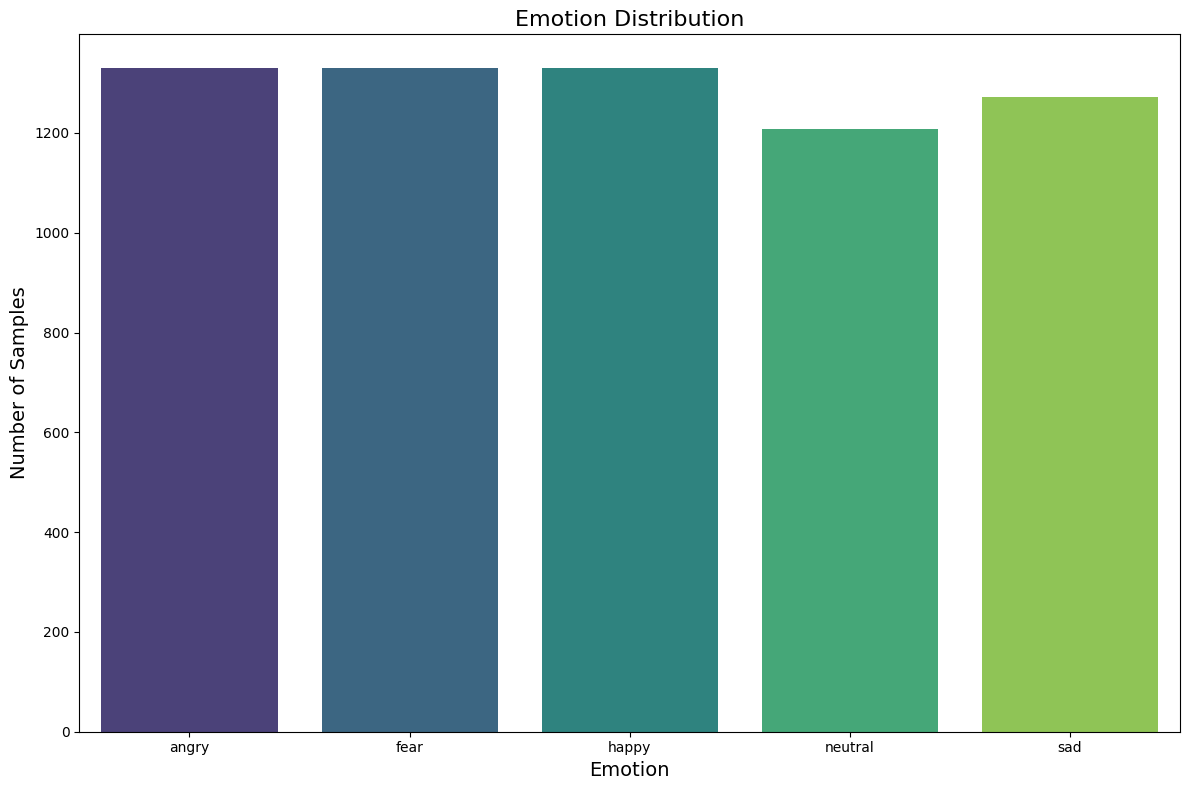

c:\Users\10\anaconda3\envs\conda_venv\lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Epoch 1/30
648/648 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4016 - loss: 1.5251 - val_accuracy: 0.5119 - val_loss: 1.1538
Epoch 2/30
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5022 - loss: 1.1775 - val_accuracy: 0.5374 - val_loss: 1.1053
Epoch 3/30
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5246 - loss: 1.1205 - val_accuracy: 0.5480 - val_loss: 1.0773
Epoch 4/30
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5432 - loss: 1.0858 - val_accuracy: 0.5604 - val_loss: 1.0492
Epoch 5/30
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5442 - loss: 1.0715 - val_accuracy: 0.5669 - val_loss: 1.0283
Epoch 6/30
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5554 - loss: 1.0451 - val_accuracy: 0.5698 - val_loss: 1.0199
Epoch 7/30
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5696 - loss: 1.0176 - val_accuracy: 0.5847 - val_loss: 1.0104
Epoch 8/30
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5795 - loss: 1.0004 - val_accuracy: 0.

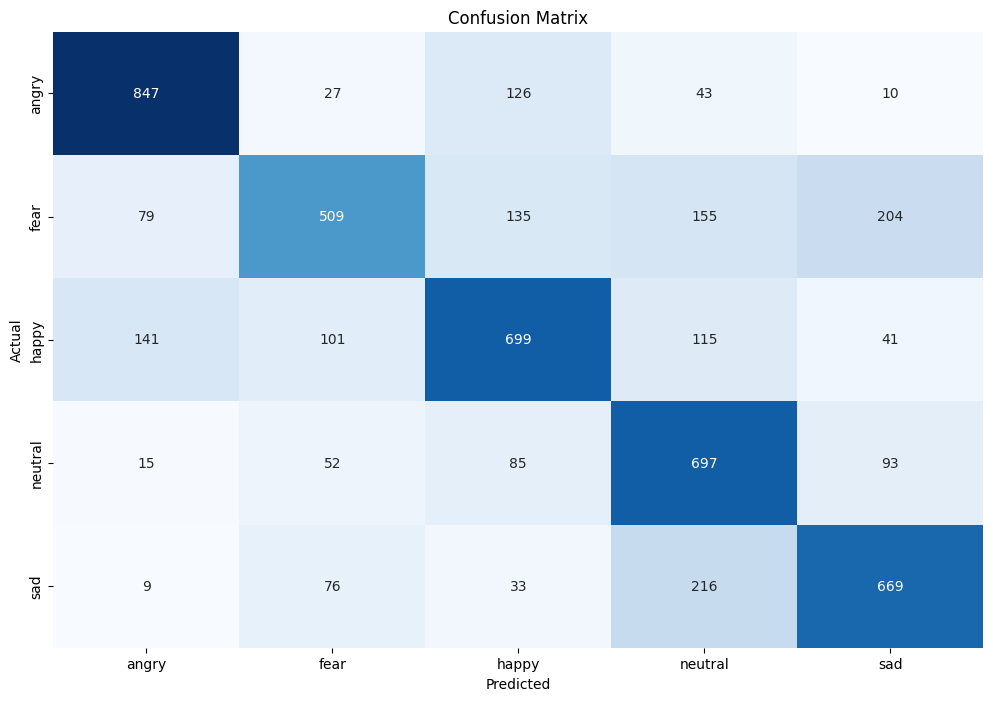

              precision    recall  f1-score   support

       angry       0.78      0.80      0.79      1053
        fear       0.67      0.47      0.55      1082
       happy       0.65      0.64      0.64      1097
     neutral       0.57      0.74      0.64       942
         sad       0.66      0.67      0.66      1003

    accuracy                           0.66      5177
   macro avg       0.66      0.66      0.66      5177
weighted avg       0.67      0.66      0.66      5177



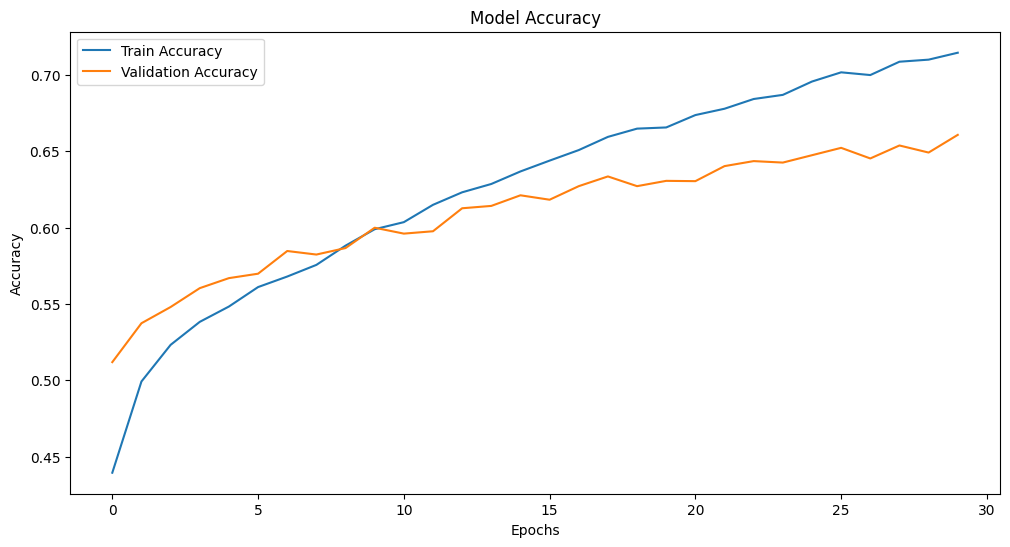

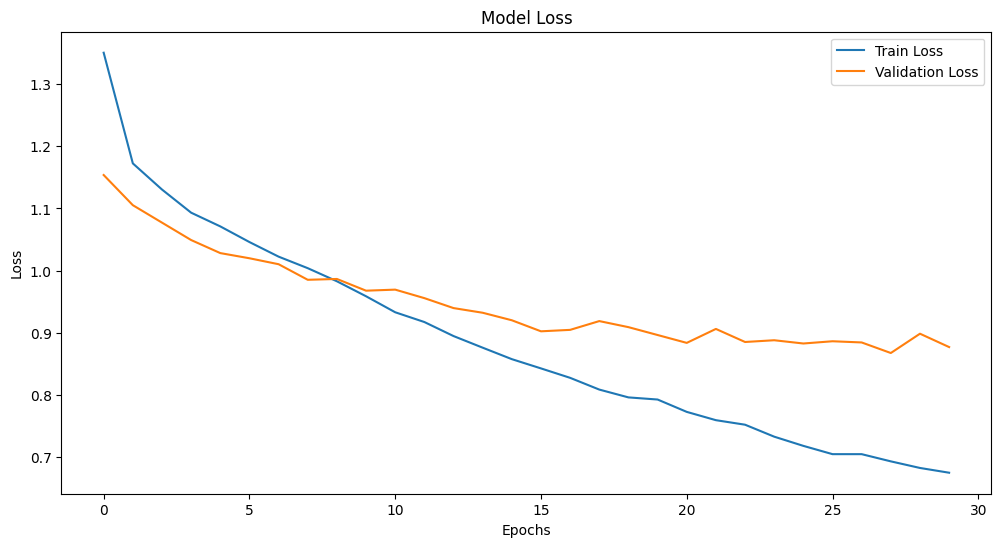

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6658 - loss: 0.8654


Test Accuracy: 66.08%


In [122]:
def main():
    df = combine_datasets()
    visualize_emotion_distribution(df)
    (X_train, X_test, y_train, y_test), encoder = prepare_data(df)
    model = build_model(input_shape=(X_train.shape[1], 1), num_classes=y_train.shape[1])
    train_and_evaluate_model(model, X_train, y_train, X_test, y_test, X_test, y_test, encoder)

    model.save("../exported_files/cnn.h5")
    with open("../exported_files/cnn_label_encoder.pkl", "wb") as handle:
        pickle.dump(encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

if __name__ == "__main__":
    main()